In [ ]:
! pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir Dataset     

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification -d Dataset  

In [4]:
import os

import torch
import torchvision
from torch import nn
from torchvision import transforms

from data import create_dataloaders
from engine import train
from utils import plot_loss_curves, calculate_performance

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
manual_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
NUM_WORKERS = os.cpu_count()
train_dir = 'Dataset/seg_train/seg_train'
test_dir = 'Dataset/seg_test/seg_test'
train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(train_dir,
                                                                                    test_dir, 
                                                                                    manual_transforms,
                                                                                    32,
                                                                                    NUM_WORKERS)

class names:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
length train data:  11034 
length validation data:  3000 
length test data:  3000


In [7]:
import pandas as pd

result_columns = ['Model Name', 'accuracy', 'f1 score', 'precision', 'recall']
result_df = pd.DataFrame(columns=result_columns)
result_model_names = ['EfficientNet',
                      'ResNet', 
                      'ResNext', 
                      'WideResNet',
                      'DenseNet',
                      'VisonTransformer',
                      'Inception',
                      'Best'
]
index = 0

## EfficientNet

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_efficient = torchvision.models.efficientnet_b0(weights=weights).to(device)
for param in model_efficient.features.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [9]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_efficient.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, 
                    bias=True)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_efficient.parameters(), lr=0.001)

In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results_efficient = train(model=model_efficient,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6738 | train_acc: 0.7866 | test_loss: 0.4142 | test_acc: 0.8602
Epoch: 2 | train_loss: 0.4488 | train_acc: 0.8419 | test_loss: 0.3736 | test_acc: 0.8701
Epoch: 3 | train_loss: 0.4169 | train_acc: 0.8488 | test_loss: 0.3563 | test_acc: 0.8649
Epoch: 4 | train_loss: 0.4095 | train_acc: 0.8511 | test_loss: 0.3498 | test_acc: 0.8723
Epoch: 5 | train_loss: 0.3867 | train_acc: 0.8621 | test_loss: 0.3429 | test_acc: 0.8753
Epoch: 6 | train_loss: 0.3770 | train_acc: 0.8639 | test_loss: 0.3433 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.3736 | train_acc: 0.8643 | test_loss: 0.3389 | test_acc: 0.8779
Epoch: 8 | train_loss: 0.3765 | train_acc: 0.8647 | test_loss: 0.3375 | test_acc: 0.8757
Epoch: 9 | train_loss: 0.3718 | train_acc: 0.8612 | test_loss: 0.3353 | test_acc: 0.8749
Epoch: 10 | train_loss: 0.3607 | train_acc: 0.8688 | test_loss: 0.3393 | test_acc: 0.8721


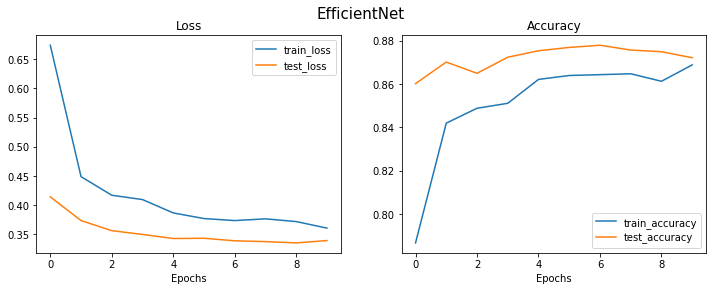

In [11]:
plot_loss_curves(results_efficient, title="EfficientNet")

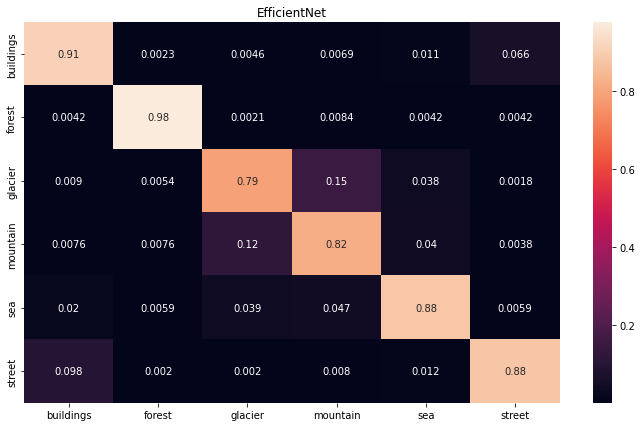

In [18]:
acc, f1, precision, recall = calculate_performance(model_efficient, 
                                              test_dataloader, 
                                              device, 
                                              class_names, 
                                              "EfficientNet")
result_df.loc[index, 'Model Name'] = result_model_names[index]
result_df.loc[index, 'accuracy'] = acc
result_df.loc[index, 'f1 score'] = f1
result_df.loc[index, 'precision'] = precision
result_df.loc[index, 'recall'] = recall
index += 1

## ResNet50

In [20]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
model_resnet = torchvision.models.resnet50(weights=weights).to(device)
for param in model_resnet.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_resnet.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, 
                    bias=True)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results_resnet = train(model=model_resnet,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5314 | train_acc: 0.8364 | test_loss: 0.3209 | test_acc: 0.8963
Epoch: 2 | train_loss: 0.3253 | train_acc: 0.8903 | test_loss: 0.2857 | test_acc: 0.8992
Epoch: 3 | train_loss: 0.2961 | train_acc: 0.8985 | test_loss: 0.2669 | test_acc: 0.9055
Epoch: 4 | train_loss: 0.2741 | train_acc: 0.9041 | test_loss: 0.2677 | test_acc: 0.9051
Epoch: 5 | train_loss: 0.2617 | train_acc: 0.9062 | test_loss: 0.2527 | test_acc: 0.9105
Epoch: 6 | train_loss: 0.2479 | train_acc: 0.9101 | test_loss: 0.2559 | test_acc: 0.9110
Epoch: 7 | train_loss: 0.2400 | train_acc: 0.9136 | test_loss: 0.2555 | test_acc: 0.9048
Epoch: 8 | train_loss: 0.2432 | train_acc: 0.9142 | test_loss: 0.2520 | test_acc: 0.9082
Epoch: 9 | train_loss: 0.2310 | train_acc: 0.9161 | test_loss: 0.2580 | test_acc: 0.9034
Epoch: 10 | train_loss: 0.2246 | train_acc: 0.9176 | test_loss: 0.2562 | test_acc: 0.9069


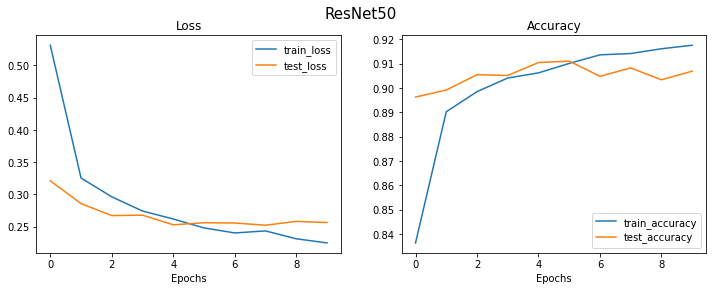

In [23]:
plot_loss_curves(results_resnet, title="ResNet50")

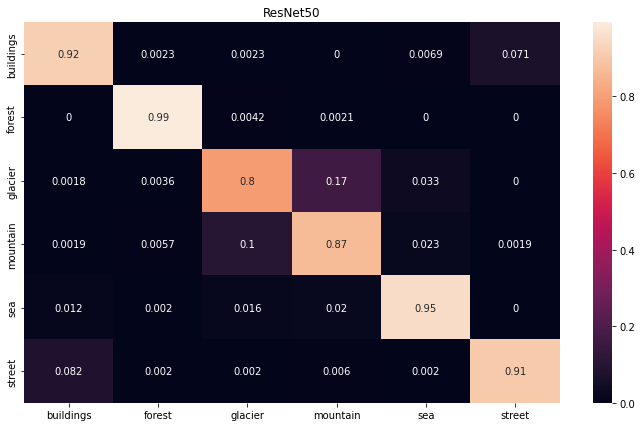

In [24]:
acc, f1, precision, recall = calculate_performance(model_resnet, 
                                              test_dataloader, 
                                              device, 
                                              class_names, 
                                              "ResNet50")
result_df.loc[index, 'Model Name'] = result_model_names[index]
result_df.loc[index, 'accuracy'] = acc
result_df.loc[index, 'f1 score'] = f1
result_df.loc[index, 'precision'] = precision
result_df.loc[index, 'recall'] = recall
index += 1

## ResNext

In [25]:
weights = torchvision.models.ResNeXt50_32X4D_Weights.DEFAULT
model_resnext = torchvision.models.resnext50_32x4d(weights=weights).to(device)
for param in model_resnext.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_resnext.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, 
                    bias=True)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnext.parameters(), lr=0.001)

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results_resnext = train(model=model_resnext,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5559 | train_acc: 0.8141 | test_loss: 0.3571 | test_acc: 0.8802
Epoch: 2 | train_loss: 0.3668 | train_acc: 0.8677 | test_loss: 0.3672 | test_acc: 0.8777
Epoch: 3 | train_loss: 0.3438 | train_acc: 0.8720 | test_loss: 0.6378 | test_acc: 0.8766
Epoch: 4 | train_loss: 0.3219 | train_acc: 0.8804 | test_loss: 0.3237 | test_acc: 0.8835
Epoch: 5 | train_loss: 0.3165 | train_acc: 0.8821 | test_loss: 0.3752 | test_acc: 0.8815
Epoch: 6 | train_loss: 0.3034 | train_acc: 0.8866 | test_loss: 0.3307 | test_acc: 0.8840
Epoch: 7 | train_loss: 0.2882 | train_acc: 0.8941 | test_loss: 0.4422 | test_acc: 0.8762
Epoch: 8 | train_loss: 0.2967 | train_acc: 0.8912 | test_loss: 0.3120 | test_acc: 0.8864
Epoch: 9 | train_loss: 0.2917 | train_acc: 0.8888 | test_loss: 0.5060 | test_acc: 0.8828
Epoch: 10 | train_loss: 0.2801 | train_acc: 0.8971 | test_loss: 0.3434 | test_acc: 0.8790


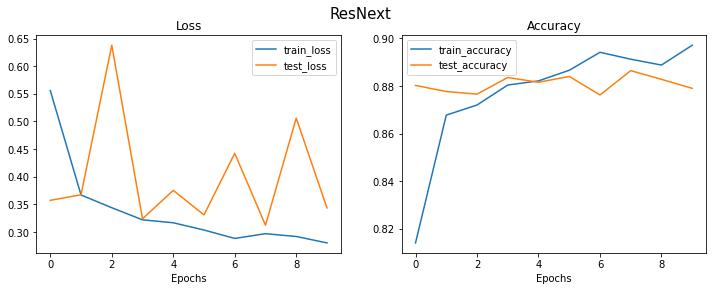

In [28]:
plot_loss_curves(results_resnext, title="ResNext")

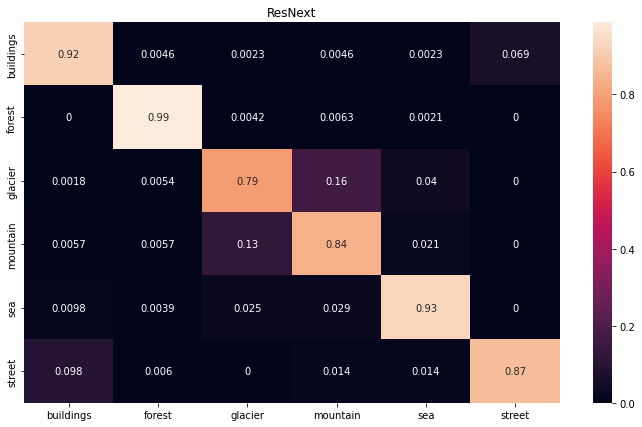

In [29]:
acc, f1, precision, recall = calculate_performance(model_resnext, 
                                              test_dataloader, 
                                              device, 
                                              class_names, 
                                              "ResNext")
result_df.loc[index, 'Model Name'] = result_model_names[index]
result_df.loc[index, 'accuracy'] = acc
result_df.loc[index, 'f1 score'] = f1
result_df.loc[index, 'precision'] = precision
result_df.loc[index, 'recall'] = recall
index += 1

## Wide ResNet

In [30]:
weights = torchvision.models.Wide_ResNet50_2_Weights.DEFAULT
model_wideresnet = torchvision.models.wide_resnet50_2(weights=weights).to(device)
for param in model_wideresnet.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-9ba9bcbe.pth


  0%|          | 0.00/263M [00:00<?, ?B/s]

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_wideresnet.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, 
                    bias=True)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_wideresnet.parameters(), lr=0.001)

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results_wideresnet = train(model=model_wideresnet,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4822 | train_acc: 0.8420 | test_loss: 0.2912 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.3033 | train_acc: 0.8950 | test_loss: 0.2706 | test_acc: 0.9077
Epoch: 3 | train_loss: 0.2749 | train_acc: 0.8996 | test_loss: 0.2804 | test_acc: 0.9089
Epoch: 4 | train_loss: 0.2625 | train_acc: 0.9021 | test_loss: 0.2624 | test_acc: 0.9117
Epoch: 5 | train_loss: 0.2435 | train_acc: 0.9109 | test_loss: 0.2716 | test_acc: 0.8986
Epoch: 6 | train_loss: 0.2274 | train_acc: 0.9155 | test_loss: 0.2527 | test_acc: 0.9070
Epoch: 7 | train_loss: 0.2256 | train_acc: 0.9153 | test_loss: 0.2634 | test_acc: 0.9045
Epoch: 8 | train_loss: 0.2250 | train_acc: 0.9148 | test_loss: 0.2551 | test_acc: 0.9074
Epoch: 9 | train_loss: 0.2137 | train_acc: 0.9215 | test_loss: 0.2574 | test_acc: 0.9086
Epoch: 10 | train_loss: 0.2113 | train_acc: 0.9220 | test_loss: 0.2798 | test_acc: 0.9031


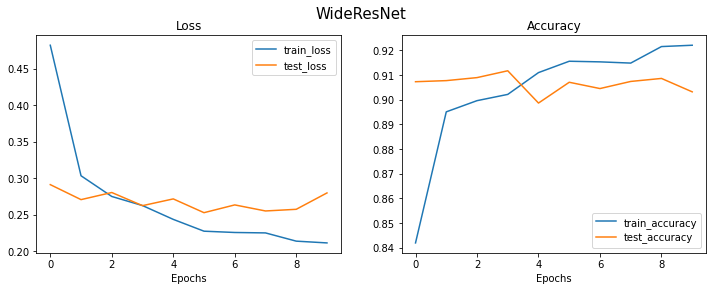

In [33]:
plot_loss_curves(results_wideresnet, title="WideResNet")

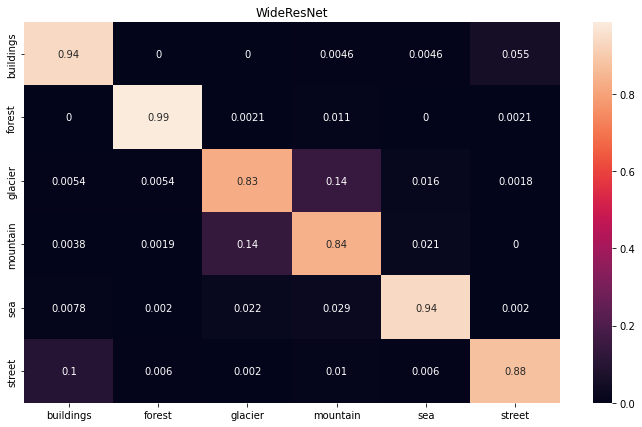

In [34]:
acc, f1, precision, recall = calculate_performance(model_wideresnet, 
                                              test_dataloader, 
                                              device, 
                                              class_names, 
                                              "WideResNet")
result_df.loc[index, 'Model Name'] = 'WideResNet'
result_df.loc[index, 'accuracy'] = acc
result_df.loc[index, 'f1 score'] = f1
result_df.loc[index, 'precision'] = precision
result_df.loc[index, 'recall'] = recall
index += 1

## DenseNet

In [35]:
weights = torchvision.models.DenseNet161_Weights.DEFAULT
model_densenet = torchvision.models.densenet161(weights=weights).to(device)
for param in model_densenet.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_densenet.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2208, 
                    out_features=output_shape, 
                    bias=True)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_densenet.parameters(), lr=0.001)

In [38]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results_densenet = train(model=model_densenet,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4994 | train_acc: 0.8361 | test_loss: 0.2940 | test_acc: 0.8934
Epoch: 2 | train_loss: 0.3215 | train_acc: 0.8841 | test_loss: 0.2792 | test_acc: 0.8987
Epoch: 3 | train_loss: 0.3159 | train_acc: 0.8853 | test_loss: 0.2662 | test_acc: 0.9053
Epoch: 4 | train_loss: 0.3035 | train_acc: 0.8926 | test_loss: 0.2726 | test_acc: 0.9024
Epoch: 5 | train_loss: 0.2887 | train_acc: 0.8943 | test_loss: 0.2628 | test_acc: 0.9080
Epoch: 6 | train_loss: 0.2805 | train_acc: 0.8946 | test_loss: 0.2720 | test_acc: 0.9069
Epoch: 7 | train_loss: 0.2665 | train_acc: 0.9018 | test_loss: 0.2589 | test_acc: 0.9059
Epoch: 8 | train_loss: 0.2782 | train_acc: 0.8964 | test_loss: 0.2544 | test_acc: 0.9086
Epoch: 9 | train_loss: 0.2750 | train_acc: 0.8959 | test_loss: 0.2822 | test_acc: 0.9040
Epoch: 10 | train_loss: 0.2686 | train_acc: 0.9005 | test_loss: 0.2644 | test_acc: 0.9031


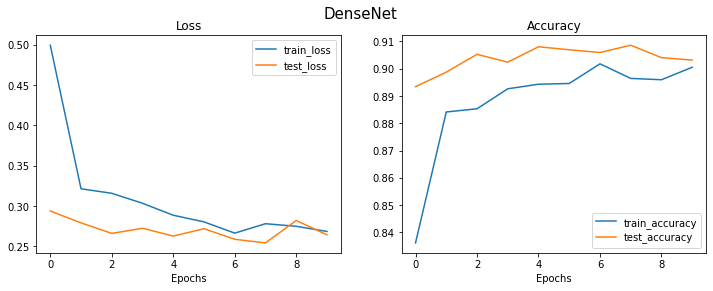

In [39]:
plot_loss_curves(results_densenet, title="DenseNet")

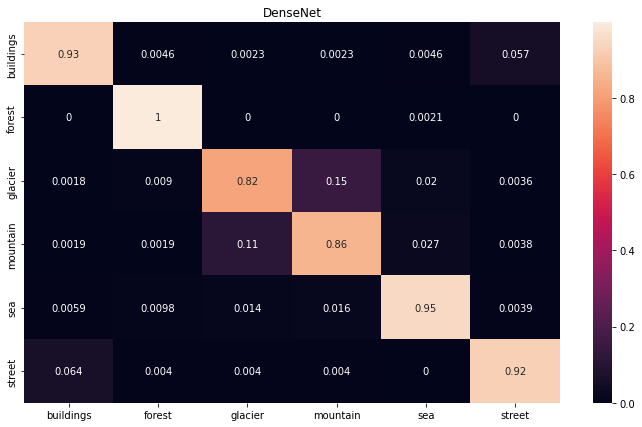

In [40]:
acc, f1, precision, recall = calculate_performance(model_densenet, 
                                              test_dataloader, 
                                              device, 
                                              class_names, 
                                              "DenseNet")
result_df.loc[index, 'Model Name'] = 'DenseNet'
result_df.loc[index, 'accuracy'] = acc
result_df.loc[index, 'f1 score'] = f1
result_df.loc[index, 'precision'] = precision
result_df.loc[index, 'recall'] = recall
index += 1

## Vison Transformer

In [47]:
manual_transforms_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [48]:
NUM_WORKERS = os.cpu_count()
train_dir = 'Dataset/seg_train/seg_train'
test_dir = 'Dataset/seg_test/seg_test'
train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(train_dir,
                                                                                    test_dir, 
                                                                                    manual_transforms_vit,
                                                                                    32,
                                                                                    NUM_WORKERS)

class names:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
length train data:  11034 
length validation data:  3000 
length test data:  3000


In [42]:
weights = torchvision.models.ViT_B_32_Weights.DEFAULT
model_vit = torchvision.models.vit_b_32(weights=weights).to(device)
for param in model_vit.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth


  0%|          | 0.00/337M [00:00<?, ?B/s]

In [45]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_vit.heads = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=768, 
                    out_features=output_shape, 
                    bias=True)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vit.parameters(), lr=0.001)

In [49]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results_vit = train(model=model_vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3205 | train_acc: 0.8921 | test_loss: 0.2264 | test_acc: 0.9167
Epoch: 2 | train_loss: 0.2144 | train_acc: 0.9217 | test_loss: 0.2051 | test_acc: 0.9221
Epoch: 3 | train_loss: 0.1924 | train_acc: 0.9288 | test_loss: 0.1981 | test_acc: 0.9238
Epoch: 4 | train_loss: 0.1819 | train_acc: 0.9361 | test_loss: 0.1992 | test_acc: 0.9273
Epoch: 5 | train_loss: 0.1735 | train_acc: 0.9386 | test_loss: 0.2043 | test_acc: 0.9240
Epoch: 6 | train_loss: 0.1696 | train_acc: 0.9389 | test_loss: 0.1997 | test_acc: 0.9238
Epoch: 7 | train_loss: 0.1648 | train_acc: 0.9388 | test_loss: 0.1974 | test_acc: 0.9242
Epoch: 8 | train_loss: 0.1605 | train_acc: 0.9420 | test_loss: 0.1962 | test_acc: 0.9229
Epoch: 9 | train_loss: 0.1593 | train_acc: 0.9392 | test_loss: 0.2053 | test_acc: 0.9258
Epoch: 10 | train_loss: 0.1559 | train_acc: 0.9427 | test_loss: 0.2069 | test_acc: 0.9266


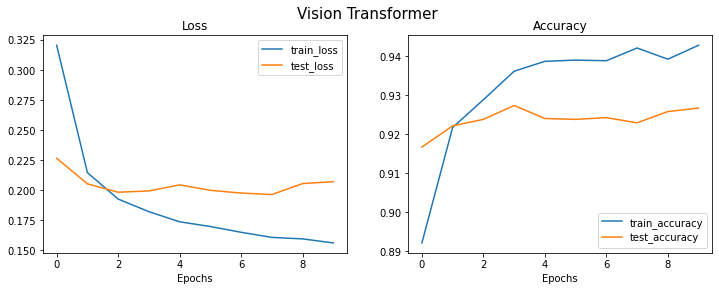

In [50]:
plot_loss_curves(results_vit, title="Vision Transformer")

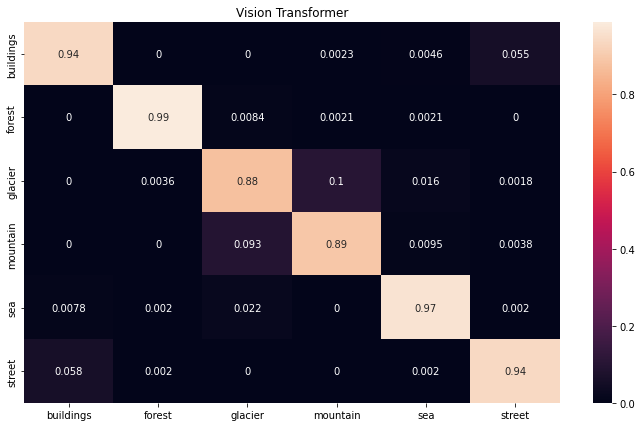

In [51]:
acc, f1, precision, recall = calculate_performance(model_vit, 
                                              test_dataloader, 
                                              device, 
                                              class_names, 
                                              "Vision Transformer")
result_df.loc[index, 'Model Name'] = 'Vision Transformer'
result_df.loc[index, 'accuracy'] = acc
result_df.loc[index, 'f1 score'] = f1
result_df.loc[index, 'precision'] = precision
result_df.loc[index, 'recall'] = recall
index += 1

## Inception

In [57]:
manual_transforms_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [58]:
NUM_WORKERS = os.cpu_count()
train_dir = 'Dataset/seg_train/seg_train'
test_dir = 'Dataset/seg_test/seg_test'
train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(train_dir,
                                                                                    test_dir, 
                                                                                    manual_transforms_inception,
                                                                                    32,
                                                                                    NUM_WORKERS)

class names:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
length train data:  11034 
length validation data:  3000 
length test data:  3000


In [64]:
weights = torchvision.models.Inception_V3_Weights.DEFAULT
model_inception = torchvision.models.inception_v3(weights=weights).to(device)
for param in model_inception.parameters():
    param.requires_grad = False

In [66]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_inception.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, 
                    bias=True)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_inception.parameters(), lr=0.0001)

In [62]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import torch


def train_step_inception(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    model.train()

    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred, _ = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step_inception(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()

    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train_inception(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step_inception(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step_inception(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [67]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results_inception = train_inception(model=model_inception,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2969 | train_acc: 0.6153 | test_loss: 0.8984 | test_acc: 0.8283
Epoch: 2 | train_loss: 0.8022 | train_acc: 0.8020 | test_loss: 0.6390 | test_acc: 0.8506
Epoch: 3 | train_loss: 0.6341 | train_acc: 0.8306 | test_loss: 0.5259 | test_acc: 0.8661
Epoch: 4 | train_loss: 0.5524 | train_acc: 0.8400 | test_loss: 0.4650 | test_acc: 0.8720
Epoch: 5 | train_loss: 0.5091 | train_acc: 0.8445 | test_loss: 0.4287 | test_acc: 0.8762
Epoch: 6 | train_loss: 0.4762 | train_acc: 0.8465 | test_loss: 0.4030 | test_acc: 0.8719
Epoch: 7 | train_loss: 0.4493 | train_acc: 0.8557 | test_loss: 0.3869 | test_acc: 0.8754
Epoch: 8 | train_loss: 0.4356 | train_acc: 0.8563 | test_loss: 0.3666 | test_acc: 0.8828
Epoch: 9 | train_loss: 0.4251 | train_acc: 0.8560 | test_loss: 0.3629 | test_acc: 0.8833
Epoch: 10 | train_loss: 0.4075 | train_acc: 0.8661 | test_loss: 0.3514 | test_acc: 0.8849


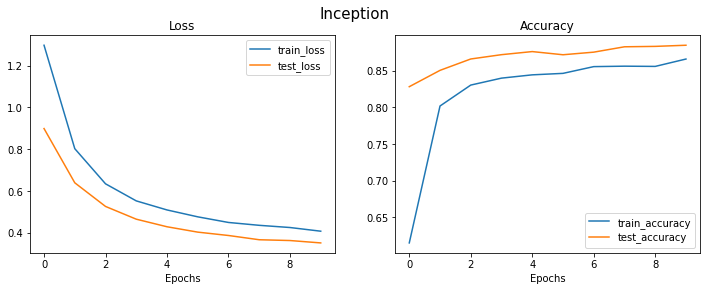

In [68]:
plot_loss_curves(results_inception, title="Inception")

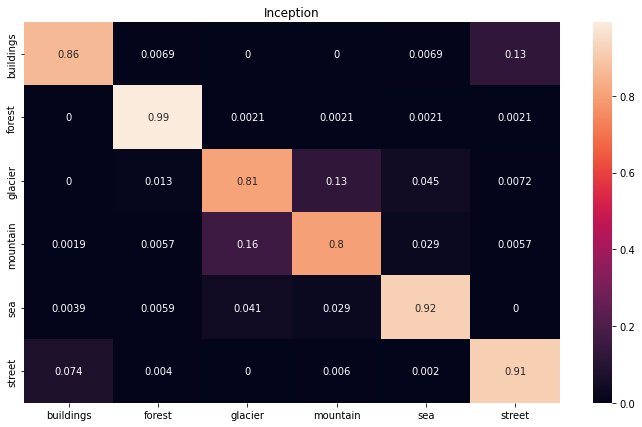

In [69]:
acc, f1, precision, recall = calculate_performance(model_inception, 
                                              test_dataloader, 
                                              device, 
                                              class_names, 
                                              "Inception")
result_df.loc[index, 'Model Name'] = 'Inception'
result_df.loc[index, 'accuracy'] = acc
result_df.loc[index, 'f1 score'] = f1
result_df.loc[index, 'precision'] = precision
result_df.loc[index, 'recall'] = recall
index += 1

In [70]:
result_df

,Model Name,accuracy,f1 score,precision,recall
0,EfficientNet,0.873005,0.875718,0.875811,0.876475
1,ResNet,0.901817,0.904158,0.904232,0.905131
2,ResNext,0.885195,0.887988,0.888307,0.888837
3,WideResNet,0.896166,0.899042,0.899442,0.899542
4,DenseNet,0.909464,0.911508,0.911008,0.912447
5,Vision Transformer,0.931848,0.933293,0.933158,0.933452
6,Inception,0.879765,0.881762,0.881935,0.882028


## Best model

In [71]:
NUM_WORKERS = os.cpu_count()
train_dir = 'Dataset/seg_train/seg_train'
test_dir = 'Dataset/seg_test/seg_test'
train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(train_dir,
                                                                                    test_dir, 
                                                                                    manual_transforms_vit,
                                                                                    32,
                                                                                    NUM_WORKERS)

class names:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
length train data:  11034 
length validation data:  3000 
length test data:  3000


In [79]:
weights = torchvision.models.ViT_B_32_Weights.DEFAULT
model_best = torchvision.models.vit_b_32(weights=weights).to(device)
for param in model_best.parameters():
    param.requires_grad = False

In [80]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_best.heads = torch.nn.Sequential(
    torch.nn.Linear(in_features=768, out_features=512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1024, out_features=output_shape)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_best.parameters(), lr=0.0001)

In [81]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results_best = train(model=model_best,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4292 | train_acc: 0.8424 | test_loss: 0.2263 | test_acc: 0.9260
Epoch: 2 | train_loss: 0.2574 | train_acc: 0.9107 | test_loss: 0.2076 | test_acc: 0.9282
Epoch: 3 | train_loss: 0.2165 | train_acc: 0.9241 | test_loss: 0.1989 | test_acc: 0.9302
Epoch: 4 | train_loss: 0.2077 | train_acc: 0.9232 | test_loss: 0.1943 | test_acc: 0.9320
Epoch: 5 | train_loss: 0.1779 | train_acc: 0.9345 | test_loss: 0.2018 | test_acc: 0.9260
Epoch: 6 | train_loss: 0.1719 | train_acc: 0.9341 | test_loss: 0.1966 | test_acc: 0.9317
Epoch: 7 | train_loss: 0.1536 | train_acc: 0.9425 | test_loss: 0.1992 | test_acc: 0.9289
Epoch: 8 | train_loss: 0.1433 | train_acc: 0.9464 | test_loss: 0.1952 | test_acc: 0.9332
Epoch: 9 | train_loss: 0.1276 | train_acc: 0.9517 | test_loss: 0.2004 | test_acc: 0.9297
Epoch: 10 | train_loss: 0.1249 | train_acc: 0.9521 | test_loss: 0.2001 | test_acc: 0.9301
Epoch: 11 | train_loss: 0.1168 | train_acc: 0.9559 | test_loss: 0.2084 | test_acc: 0.9307
Epoch: 12 | train_l

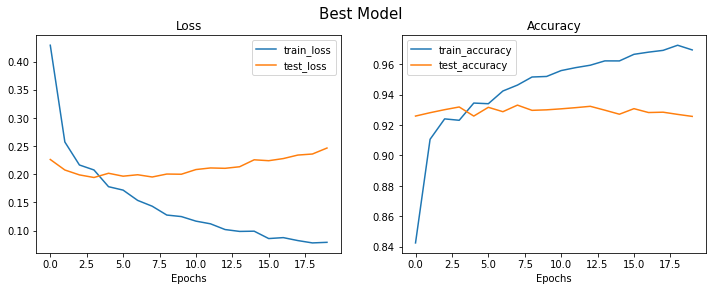

In [82]:
plot_loss_curves(results_best, title="Best Model")

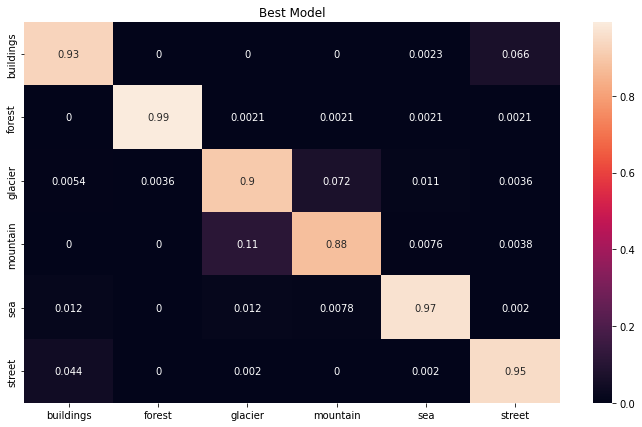

In [83]:
acc, f1, precision, recall = calculate_performance(model_best, 
                                              test_dataloader, 
                                              device, 
                                              class_names, 
                                              "Best Model")
result_df.loc[index, 'Model Name'] = 'Best Model'
result_df.loc[index, 'accuracy'] = acc
result_df.loc[index, 'f1 score'] = f1
result_df.loc[index, 'precision'] = precision
result_df.loc[index, 'recall'] = recall

## Aggregating the results

In [84]:
result_df

,Model Name,accuracy,f1 score,precision,recall
0,EfficientNet,0.873005,0.875718,0.875811,0.876475
1,ResNet,0.901817,0.904158,0.904232,0.905131
2,ResNext,0.885195,0.887988,0.888307,0.888837
3,WideResNet,0.896166,0.899042,0.899442,0.899542
4,DenseNet,0.909464,0.911508,0.911008,0.912447
5,Vision Transformer,0.931848,0.933293,0.933158,0.933452
6,Inception,0.879765,0.881762,0.881935,0.882028
7,Best Model,0.936059,0.937351,0.937566,0.937321


In [85]:
result_df.sort_values(by=['accuracy'], ascending=False, inplace=True)
result_df

,Model Name,accuracy,f1 score,precision,recall
7,Best Model,0.936059,0.937351,0.937566,0.937321
5,Vision Transformer,0.931848,0.933293,0.933158,0.933452
4,DenseNet,0.909464,0.911508,0.911008,0.912447
1,ResNet,0.901817,0.904158,0.904232,0.905131
3,WideResNet,0.896166,0.899042,0.899442,0.899542
2,ResNext,0.885195,0.887988,0.888307,0.888837
6,Inception,0.879765,0.881762,0.881935,0.882028
0,EfficientNet,0.873005,0.875718,0.875811,0.876475
